# IMPORTS

In [2]:
import pandas as pd
import numpy as np
import openpyxl

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker

from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, cross_validate, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.tree import export_graphviz
from sklearn.neighbors import NearestNeighbors
import graphviz
import sklearn

import seaborn as sns

from IPython.display import display

import math
from scipy.interpolate import Rbf
from sklearn.neighbors import NearestNeighbors

random_state = 1

import pickle
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['font.size'] = 10

# LOADING DATASET

In [3]:
####### Load expt and DFT data
excel = "computed_data"
expt_sheet = "expt_data"
br_sheet = "DFT_arbr"
amine_sheet = "DFT_am"
lig_sheet = "DFT_lig"

expt_df = pd.read_excel(excel + ".xlsx", expt_sheet, header=1, engine='openpyxl')
br_load = pd.read_excel(excel+".xlsx",br_sheet,header=None, engine='openpyxl')
am_load = pd.read_excel(excel+".xlsx",amine_sheet,header=None, engine='openpyxl')
lig_load = pd.read_excel(excel+".xlsx",lig_sheet,header=None, engine='openpyxl')
# display(expt_df)

In [4]:
def process_dataframe(input_df):
    processed_df = input_df.copy()
    column_names = [
        processed_df.iloc[1][col] if col in processed_df.columns[0:2]
        else processed_df.iloc[0][col] + "_" + processed_df.iloc[1][col]
        for col in processed_df.columns
    ]

    processed_df.columns = column_names
    processed_df = processed_df.iloc[2:]
    processed_df.reset_index(drop=True, inplace=True)
    
    columns_to_keep = [
        col for col in processed_df.columns
        if col.endswith("Name") or col.endswith("smiles") or col.endswith("min") or col.endswith("max")
    ]
    processed_df = processed_df[columns_to_keep]
    return processed_df

br = process_dataframe(br_load)
amine = process_dataframe(am_load)
ligands = process_dataframe(lig_load)
# display(br)

# PRE-PROCESSING

## NORMALIZE

In [5]:
def normalize_dataframe(dataframe, variance_threshold=0.0):
    normalized_df = dataframe.copy()
    columns_to_normalize = dataframe.columns[2:]
    scaler = MinMaxScaler()
    normalized_df[columns_to_normalize] = scaler.fit_transform(dataframe[columns_to_normalize])
    
    selector = VarianceThreshold(threshold=variance_threshold)
    selected_columns = selector.fit_transform(normalized_df[columns_to_normalize])
    normalized_df = normalized_df.iloc[:, :2].join(pd.DataFrame(selected_columns, columns=columns_to_normalize[selector.get_support()]))
    
    return normalized_df

br_norm = normalize_dataframe(br, variance_threshold=0.0)
am_norm = normalize_dataframe(amine, variance_threshold=0.0)
lig_norm = normalize_dataframe(ligands, variance_threshold=0.0)

## CLEANING INDIVIDUAL DFS

In [6]:
def correlated_pairs(dataframe, threshold=0.95):
    df_corr = dataframe.corr().abs()
    upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(bool))
    correlated_pairs = []
    for col1 in upper.columns:
        for col2 in upper.columns:
            if col1 != col2 and upper[col1][col2] > threshold:
                correlated_pairs.append((col1, col2))
    if correlated_pairs:
        print(f"Highly correlated column pairs with a correlation coefficient above {threshold}:")
        for col1, col2 in correlated_pairs:
            print(f"Correlated Pair: {col1} : {col2}")
    else:
        print("No highly correlated column pairs found.")

    return None

def drop_columns(dataframe, substrings):
    columns_to_drop = [col for col in dataframe.columns if any(substring in col for substring in substrings)]
    return dataframe.drop(columns=columns_to_drop)

In [7]:
# FILTER UNINTERPRETABLE OR REPEATITIVE FEATURES

br_filter_1 = ['μ', 'η', 'ω', 'polar', 'NMR','Sterimol',
            'Vbur_Br', 'Hirsh', 'C_3.0Å', 'C_3.5Å', 'C_4.0Å']
br_filtered = drop_columns(br_norm, br_filter_1)

#######
am_filter_1 = ['μ', 'η', 'ω', 'polar', 'NMR','Sterimol',
            'Hirsh', '3.0Å', '3.5Å', '4.0Å']

am_filtered = drop_columns(am_norm, am_filter_1)

#######

lig_filter_1 = ['μ', 'η', 'ω', 'polar', 'NMR',
            'Hirsh', 'Cu_2.0Å', 'Cu_2.5Å']

lig_filtered = drop_columns(lig_norm, lig_filter_1)

In [8]:
correlated_pairs(br_filtered, threshold=0.95)

print('--------------------------------------')
br_filter_2 = ['Br_6', 'Br_7', 'Br_39', 'Br_43', 'Br_46', 'Br_47', 'Br_51', 'Br_55', 'Br_67', 'Br_75', 'Br_74', 'Br_83']

br_clean = drop_columns(br_filtered, br_filter_2)
correlated_pairs(br_clean, threshold=0.95)

Highly correlated column pairs with a correlation coefficient above 0.95:
Correlated Pair: Br_7_LUMO_max : Br_6_LUMO_min
Correlated Pair: Br_39_SASA_sphericity_max : Br_38_SASA_sphericity_min
Correlated Pair: Br_43_SASA_surface_area(Å²)_max : Br_38_SASA_sphericity_min
Correlated Pair: Br_43_SASA_surface_area(Å²)_max : Br_42_SASA_surface_area(Å²)_min
Correlated Pair: Br_46_SASA_volume(Å³)_min : Br_35_volume(Bohr_radius³/mol)_max
Correlated Pair: Br_46_SASA_volume(Å³)_min : Br_42_SASA_surface_area(Å²)_min
Correlated Pair: Br_46_SASA_volume(Å³)_min : Br_43_SASA_surface_area(Å²)_max
Correlated Pair: Br_47_SASA_volume(Å³)_max : Br_35_volume(Bohr_radius³/mol)_max
Correlated Pair: Br_47_SASA_volume(Å³)_max : Br_42_SASA_surface_area(Å²)_min
Correlated Pair: Br_47_SASA_volume(Å³)_max : Br_43_SASA_surface_area(Å²)_max
Correlated Pair: Br_47_SASA_volume(Å³)_max : Br_46_SASA_volume(Å³)_min
Correlated Pair: Br_51_NBO_charge_Br_max : Br_50_NBO_charge_Br_min
Correlated Pair: Br_55_NBO_charge_C_max : 

In [9]:
correlated_pairs(am_filtered, threshold=0.95)

print('--------------------------------------')
am_filter_2 = ['Am_3', 'Am_7', 'Am_39', 'Am_43', 'Am_46', 'Am_47', 'Am_50', 'Am_51', 'Am_54', 'Am_67',
              'Am_71', 'Am_79', 'Am_66', 'Am_183', 'Am_182', 'Am_186', 'Am_187']

am_clean = drop_columns(am_filtered, am_filter_2)
correlated_pairs(am_clean, threshold=0.95)

Highly correlated column pairs with a correlation coefficient above 0.95:
Correlated Pair: Am_3_HOMO_max : Am_2_HOMO_min
Correlated Pair: Am_7_LUMO_max : Am_6_LUMO_min
Correlated Pair: Am_39_SASA_sphericity_max : Am_38_SASA_sphericity_min
Correlated Pair: Am_43_SASA_surface_area(Å²)_max : Am_42_SASA_surface_area(Å²)_min
Correlated Pair: Am_46_SASA_volume(Å³)_min : Am_42_SASA_surface_area(Å²)_min
Correlated Pair: Am_46_SASA_volume(Å³)_min : Am_43_SASA_surface_area(Å²)_max
Correlated Pair: Am_47_SASA_volume(Å³)_max : Am_42_SASA_surface_area(Å²)_min
Correlated Pair: Am_47_SASA_volume(Å³)_max : Am_43_SASA_surface_area(Å²)_max
Correlated Pair: Am_47_SASA_volume(Å³)_max : Am_46_SASA_volume(Å³)_min
Correlated Pair: Am_51_NBO_charge_C_max : Am_50_NBO_charge_C_min
Correlated Pair: Am_67_distance_C_N(Å)_max : Am_50_NBO_charge_C_min
Correlated Pair: Am_67_distance_C_N(Å)_max : Am_51_NBO_charge_C_max
Correlated Pair: Am_67_distance_C_N(Å)_max : Am_66_distance_C_N(Å)_min
Correlated Pair: Am_71_%Vbu

In [10]:
correlated_pairs(lig_filtered, threshold=0.95)

print('--------------------------------------')
lig_filter_2 = ['Lig_8', 'Lig_7', 'Lig_14', 'Lig_68', 'Lig_80', 'Lig_67', 'Lig_74', 'Lig_133', 'Lig_134', 'Lig_139', 'Lig_152']

lig_clean = drop_columns(lig_filtered, lig_filter_2)
correlated_pairs(lig_clean, threshold=0.95)

Highly correlated column pairs with a correlation coefficient above 0.95:
Correlated Pair: Lig_8_HOMO_max : Lig_7_HOMO_min
Correlated Pair: Lig_14_LUMO_max : Lig_13_LUMO_min
Correlated Pair: Lig_68_SASA_surface_area(Å²)_max : Lig_67_SASA_surface_area(Å²)_min
Correlated Pair: Lig_73_SASA_volume(Å³)_min : Lig_67_SASA_surface_area(Å²)_min
Correlated Pair: Lig_73_SASA_volume(Å³)_min : Lig_68_SASA_surface_area(Å²)_max
Correlated Pair: Lig_74_SASA_volume(Å³)_max : Lig_67_SASA_surface_area(Å²)_min
Correlated Pair: Lig_74_SASA_volume(Å³)_max : Lig_68_SASA_surface_area(Å²)_max
Correlated Pair: Lig_74_SASA_volume(Å³)_max : Lig_73_SASA_volume(Å³)_min
Correlated Pair: Lig_80_NBO_charge_Cu_max : Lig_79_NBO_charge_Cu_min
Correlated Pair: Lig_133_%Vbur_Cu_3.5Å_min : Lig_127_%Vbur_Cu_3.0Å_min
Correlated Pair: Lig_134_%Vbur_Cu_3.5Å_max : Lig_128_%Vbur_Cu_3.0Å_max
Correlated Pair: Lig_139_%Vbur_Cu_4.0Å_min : Lig_127_%Vbur_Cu_3.0Å_min
Correlated Pair: Lig_139_%Vbur_Cu_4.0Å_min : Lig_133_%Vbur_Cu_3.5Å_min

## BACK TO NON-NORMALIZED DFs

In [11]:
common_br = br.columns.intersection(br_clean.columns)
final_br = br[common_br]
common_am = amine.columns.intersection(am_clean.columns)
final_am = amine[common_am]
common_lig = ligands.columns.intersection(lig_clean.columns)
final_lig = ligands[common_lig]

# display(final_br)
# display(final_am)
# display(final_lig)

## COMBINING DATAFRAMES

In [12]:
result_df = expt_df.copy()

for index, row in expt_df.iterrows():
    aryl_bromide = row["Aryl_Bromide"]
    compound_row = final_br[final_br["Compound_Name"] == aryl_bromide]
    if not compound_row.empty:
        result_df.loc[index, compound_row.columns[2:]] = compound_row.values[0, 2:]
for index, row in expt_df.iterrows():
    primary_amine = row["Amine"]
    compound_row = final_am[final_am["Compound_Name"] == primary_amine]
    if not compound_row.empty:
        result_df.loc[index, compound_row.columns[2:]] = compound_row.values[0, 2:]
for index, row in expt_df.iterrows():
    ligand = row["Ligands"]
    compound_row = final_lig[final_lig["Compound_Name"] == ligand]
    if not compound_row.empty:
        result_df.loc[index, compound_row.columns[2:]] = compound_row.values[0, 2:]
    
display(result_df)

,Product,Aryl_Bromide,Amine,Ligands,Yield,Br_2_HOMO_min,Br_3_HOMO_max,Br_30_dipole(Debye)_min,Br_31_dipole(Debye)_max,Br_34_volume(Bohr_radius³/mol)_min,...,Lig_163_Sterimol_B5_I_Cu(Å)_morfeus_min,Lig_164_Sterimol_B5_I_Cu(Å)_morfeus_max,Lig_169_Sterimol_L_I_Cu(Å)_morfeus_min,Lig_170_Sterimol_L_I_Cu(Å)_morfeus_max,Lig_175_Buried_Sterimol_B1_I_Cu_4.5(Å)_min,Lig_176_Buried_Sterimol_B1_I_Cu_4.5(Å)_max,Lig_181_Buried_Sterimol_B5_I_Cu_4.5(Å)_min,Lig_182_Buried_Sterimol_B5_I_Cu_4.5(Å)_max,Lig_187_Buried_Sterimol_L_I_Cu_4.5(Å)_min,Lig_188_Buried_Sterimol_L_I_Cu_4.5(Å)_max
0,P100,alle_151,alln_146,Ligand_25,37.745651,-0.31849,-0.31428,1.9452,4.5518,1278.615,...,7.524264,9.258364,8.287072,8.500650,1.960000,3.196584,5.183091,6.852622,6.090476,7.379700
1,P100,alle_151,alln_146,Ligand_26,32.314681,-0.31849,-0.31428,1.9452,4.5518,1278.615,...,6.056198,7.743204,8.324027,8.412293,2.049641,2.777705,6.056198,6.497189,6.246761,7.382139
2,P100,alle_151,alln_146,Ligand_27,54.574285,-0.31849,-0.31428,1.9452,4.5518,1278.615,...,7.968890,7.998244,8.333930,8.354252,1.960000,3.011519,6.525822,6.531211,7.336084,7.350043
3,P100,alle_151,alln_146,Ligand_28,23.920929,-0.31849,-0.31428,1.9452,4.5518,1278.615,...,6.620305,9.737104,8.308582,9.135993,1.960000,4.151107,6.174758,6.482128,6.214650,7.343286
4,P100,alle_151,alln_146,Ligand_29,31.057869,-0.31849,-0.31428,1.9452,4.5518,1278.615,...,8.652491,8.716654,8.271261,8.316819,1.973322,3.015300,6.364853,6.581254,7.264352,7.283059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,P218,alle_2012,alln_2001,Ligand_33,37.567264,-0.29316,-0.29316,2.0731,2.0731,1893.411,...,7.585035,7.586199,8.407911,8.409097,1.960000,1.960000,5.144980,5.146654,7.263844,7.264013
796,P219,alle_2012,alln_2006,Ligand_1,0.724934,-0.29316,-0.29316,2.0731,2.0731,1893.411,...,5.839763,5.839763,10.211682,10.211682,1.960000,1.960000,4.493311,4.493311,7.386369,7.386369
797,P219,alle_2012,alln_2006,Ligand_21,1.233679,-0.29316,-0.29316,2.0731,2.0731,1893.411,...,7.058438,7.189072,10.190264,10.588418,1.960000,1.960000,2.932049,2.951312,5.917673,7.285306
798,P219,alle_2012,alln_2006,Ligand_28,1.405341,-0.29316,-0.29316,2.0731,2.0731,1893.411,...,6.620305,9.737104,8.308582,9.135993,1.960000,4.151107,6.174758,6.482128,6.214650,7.343286


# PREPARE TRAINING & VALIDATION DF

In [13]:
initial_training_df = result_df[result_df['Product'].str[1:].astype(int) < 112]

training_df = result_df[result_df['Product'].str[1:].astype(int) < 200]
validation_df = result_df[result_df['Product'].str[1:].astype(int) >= 200]

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

# display(initial_training_df)
display(training_df)
display(validation_df)

,Product,Aryl_Bromide,Amine,Ligands,Yield,...,Lig_176_Buried_Sterimol_B1_I_Cu_4.5(Å)_max,Lig_181_Buried_Sterimol_B5_I_Cu_4.5(Å)_min,Lig_182_Buried_Sterimol_B5_I_Cu_4.5(Å)_max,Lig_187_Buried_Sterimol_L_I_Cu_4.5(Å)_min,Lig_188_Buried_Sterimol_L_I_Cu_4.5(Å)_max
0,P100,alle_151,alln_146,Ligand_25,37.745651,...,3.196584,5.183091,6.852622,6.090476,7.379700
1,P100,alle_151,alln_146,Ligand_26,32.314681,...,2.777705,6.056198,6.497189,6.246761,7.382139
2,P100,alle_151,alln_146,Ligand_27,54.574285,...,3.011519,6.525822,6.531211,7.336084,7.350043
3,P100,alle_151,alln_146,Ligand_28,23.920929,...,4.151107,6.174758,6.482128,6.214650,7.343286
4,P100,alle_151,alln_146,Ligand_29,31.057869,...,3.015300,6.364853,6.581254,7.264352,7.283059
...,...,...,...,...,...,...,...,...,...,...,...
715,P127,alle_7,alln_4,Ligand_32,6.254441,...,1.960000,5.834016,5.844650,7.213562,7.281235
716,P127,alle_7,alln_4,Ligand_33,21.540929,...,1.960000,5.144980,5.146654,7.263844,7.264013
717,P127,alle_7,alln_4,Ligand_34,15.320154,...,1.960000,5.913880,5.923100,7.227785,7.229075
718,P127,alle_7,alln_4,Ligand_35,24.007300,...,1.960000,5.189866,5.190071,7.303196,7.303471


,Product,Aryl_Bromide,Amine,Ligands,Yield,...,Lig_176_Buried_Sterimol_B1_I_Cu_4.5(Å)_max,Lig_181_Buried_Sterimol_B5_I_Cu_4.5(Å)_min,Lig_182_Buried_Sterimol_B5_I_Cu_4.5(Å)_max,Lig_187_Buried_Sterimol_L_I_Cu_4.5(Å)_min,Lig_188_Buried_Sterimol_L_I_Cu_4.5(Å)_max
720,P200,alle_148,alln_2003,Ligand_1,0.000000,...,1.960000,4.493311,4.493311,7.386369,7.386369
721,P200,alle_148,alln_2003,Ligand_21,30.180000,...,1.960000,2.932049,2.951312,5.917673,7.285306
722,P200,alle_148,alln_2003,Ligand_28,35.754412,...,4.151107,6.174758,6.482128,6.214650,7.343286
723,P200,alle_148,alln_2003,Ligand_33,30.379593,...,1.960000,5.144980,5.146654,7.263844,7.264013
724,P201,alle_148,alln_2004,Ligand_1,0.078765,...,1.960000,4.493311,4.493311,7.386369,7.386369
...,...,...,...,...,...,...,...,...,...,...,...
795,P218,alle_2012,alln_2001,Ligand_33,37.567264,...,1.960000,5.144980,5.146654,7.263844,7.264013
796,P219,alle_2012,alln_2006,Ligand_1,0.724934,...,1.960000,4.493311,4.493311,7.386369,7.386369
797,P219,alle_2012,alln_2006,Ligand_21,1.233679,...,1.960000,2.932049,2.951312,5.917673,7.285306
798,P219,alle_2012,alln_2006,Ligand_28,1.405341,...,4.151107,6.174758,6.482128,6.214650,7.343286


# DECISION TREE

## TRAINING

There are 560 reactions with yields between 0-20%
There are 160 reactions with yields between 20%+


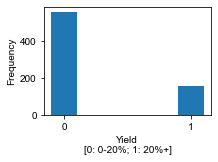

In [14]:
data = training_df.copy()

properties_start = 5
response = 4

X = data.iloc[:,properties_start:].values
y = data["Yield"]
y_class = np.array([0 if i < 20 else 1 for i in y])
y_class = y_class.astype(int)

X_labelname = data.columns[properties_start:].tolist()

count_zero = np.count_nonzero(y_class == 0)
print(f"There are {count_zero} reactions with yields between 0-20%")
count_ones = np.count_nonzero(y_class == 1)
print(f"There are {count_ones} reactions with yields between 20%+")

fig, ax = plt.subplots(figsize=(3, 2))

# Your code to plot the histogram
plt.hist(y_class, bins=[-0.1, 0.1, 0.9, 1.1])
plt.xlabel('Yield \n[0: 0-20%; 1: 20%+]')
plt.ylabel('Frequency')
plt.xticks([0, 1])

plt.show()

### GRID SEARCH

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=.25, shuffle=True, random_state=random_state)

kfold = KFold(n_splits=4, shuffle=True, random_state=random_state)
param_grid = {'criterion': ['gini','entropy'],
              'class_weight': [{0:1,1:3},{0:1,1:4},{0:1,1:5},{0:1,1:6}],
             'max_depth': [2,3,4,5]}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=kfold, return_train_score=True)
grid_search.fit(X_train, y_train)

print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

results_grid = pd.DataFrame(grid_search.cv_results_)

Best parameters: {'class_weight': {0: 1, 1: 3}, 'criterion': 'entropy', 'max_depth': 3}
Best cross-validation score: 0.85


### FINAL DT

Accuracy: 0.88
Precision: 0.89
Recall: 0.87
F1 Score: 0.84


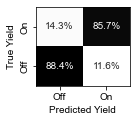

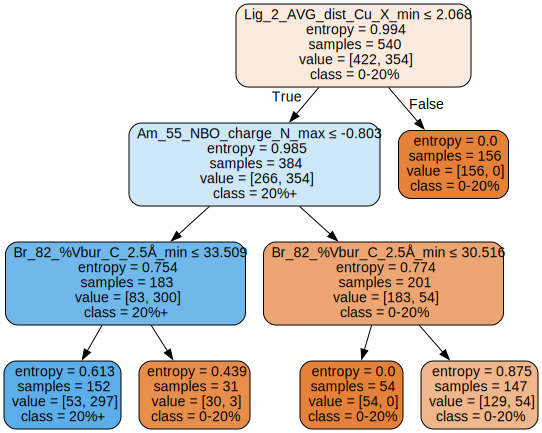

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.25, shuffle=True, random_state=random_state)

class_weight={0:1.0, 1:3.0}

model_final = DecisionTreeClassifier(random_state=random_state,
                               max_depth=3,
                               criterion='entropy',
                               min_samples_split=3,
                               min_samples_leaf=3,
                               max_features=None,
                               class_weight=class_weight 
                              )

#####################################
model_final.fit(X_train, y_train)
y_pred = model_final.predict(X_test)

#####################################
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,average='weighted')
recall = recall_score(y_test, y_pred,average='macro')
f1 = f1_score(y_test, y_pred,average='macro')

print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))
#####################################
fig, ax = plt.subplots(figsize=(2,1.8))
cm = confusion_matrix(y_test, y_pred, normalize='true')
cm = np.flipud(cm)

yticklabels = list(reversed(['Off', 'On'])) 
res = sns.heatmap(cm, annot=True, cmap='Greys', fmt='.1%',cbar=False, yticklabels=yticklabels)
for _, spine in res.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(0.75)
    
ax.set_xlabel('Predicted Yield')
ax.set_ylabel('True Yield',font="Arial")
ax.set_xticks([0.5, 1.5], ['Off', 'On'])
ax.set_yticks([0.5, 1.5], ['On', 'Off'])

fig.tight_layout()
# fig.savefig("cm.png", dpi=600, bbox_inches='tight')
plt.show()
#####################################
dot_data = export_graphviz(model_final, out_file=None,
                           feature_names=X_labelname,
                           class_names=['0-20%', '20%+'],
                           filled=True, rounded=True,
                           special_characters=True)

graph = graphviz.Source(dot_data)
graph

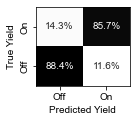

In [17]:
#####################################
fig, ax = plt.subplots(figsize=(2,1.8))
cm = confusion_matrix(y_test, y_pred, normalize='true')
cm = np.flipud(cm)

yticklabels = ('Off', 'On') 
res = sns.heatmap(cm, annot=True, cmap='Greys', fmt='.1%',cbar=False, yticklabels=yticklabels)
for _, spine in res.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(0.75)
    
ax.set_xlabel('Predicted Yield')
ax.set_ylabel('True Yield',font="Arial")
ax.set_xticks([0.5, 1.5], ['Off', 'On'])
ax.set_yticks([0.5, 1.5], ['On', 'Off'])

fig.tight_layout()
# fig.savefig("cm.png", dpi=600, bbox_inches='tight')
plt.show()
#####################################

Average cross-validation score: 0.86


,fit_time,score_time,test_score,train_score
0,0.002668,0.000430,0.877778,0.866667
1,0.002158,0.000324,0.822222,0.850000
2,0.002119,0.000334,0.872222,0.868519
3,0.002227,0.000330,0.861111,0.872222


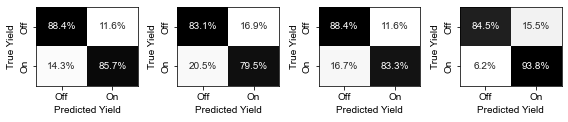

In [18]:
#####################################
kfold = KFold(n_splits=4, shuffle=True, random_state=random_state)
scores = cross_val_score(model_final, X, y_class, cv=kfold)
average_score = scores.mean()
scores_new = cross_validate(model_final, X, y_class, cv=kfold, return_train_score = True)
print("Average cross-validation score: {:.2f}".format(average_score))
display(pd.DataFrame(scores_new))
#####################################
confusion_matrices = []
# Perform k-fold cross-validation
for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y_class[train_idx], y_class[test_idx]

    # Train your model on the training data
    model_final.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model_final.predict(X_test)

    # Calculate the confusion matrix for this fold
    cm = confusion_matrix(y_test, y_pred, normalize='true')

    # Append the confusion matrix to the list
    confusion_matrices.append(cm)
#####################################
# Create a figure with subplots in a single row
fig, axes = plt.subplots(1, len(confusion_matrices), figsize=(2 * len(confusion_matrices), 1.8))
yticklabels = ('Off', 'On')

# Enumerate over the confusion matrices and plot them in the subplots
for i, cm in enumerate(confusion_matrices):
    ax = axes[i]
    res = sns.heatmap(cm, annot=True, cmap='Greys', fmt='.1%', cbar=False, yticklabels=yticklabels, ax=ax)
    for _, spine in res.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.75)

    ax.set_xlabel('Predicted Yield')
    ax.set_ylabel('True Yield', font="Arial")
    ax.set_xticks([0.5, 1.5], ['Off', 'On'])
    ax.set_yticks([0.5, 1.5], ['Off', 'On'])

fig.tight_layout()
plt.show()

### EXPORT DT

In [ ]:
#### NEED TO MAKE A NEW DF WITH THREE FEATURES ONLY

# filename = 'dt_model.pkl'
# with open(filename, 'wb') as file:
#     pickle.dump(model_final, file)

# VALIDATION

## DT CHEMICAL SPACE 

In [19]:
map_df = result_df.copy()

prefixes_to_find = ['Br_82_', 'Am_55_']
selected_columns = map_df.columns[0:5].tolist()
found_columns = [col for col in map_df.columns if any(col.startswith(prefix) for prefix in prefixes_to_find)]
selected_columns.extend(found_columns)
map_df = map_df[selected_columns]

map_initial_training = map_df[map_df['Product'].str[1:].astype(int) < 112]
map_training = map_df[map_df['Product'].str[1:].astype(int) < 200]
map_validation = map_df[map_df['Product'].str[1:].astype(int) >= 200]

# display(map_training)
# display(map_validation)

In [20]:
br_name = "Br_82_%Vbur_C_2.5Å_min"
am_name = "Am_55_NBO_charge_N_max"
lig_name = "Lig_2_AVG_dist_Cu_X_min"

grouped_ini_train = map_initial_training.groupby('Product')['Yield'].mean().reset_index()
grouped_ini_train = map_initial_training.groupby('Product').agg({'Aryl_Bromide': 'first', 'Amine': 'first', 'Ligands': 'first', 'Yield': 'mean', br_name: 'first', am_name: 'first'}).reset_index()
grouped_ini_train = grouped_ini_train.rename(columns={'Yield': 'average_yield'})


grouped_train = map_training.groupby('Product')['Yield'].mean().reset_index()
grouped_train = map_training.groupby('Product').agg({'Aryl_Bromide': 'first', 'Amine': 'first', 'Ligands': 'first', 'Yield': 'mean', br_name: 'first', am_name: 'first'}).reset_index()
grouped_train = grouped_train.rename(columns={'Yield': 'average_yield'})

grouped_val = map_validation.groupby('Product')['Yield'].mean().reset_index()
grouped_val = map_validation.groupby('Product').agg({'Aryl_Bromide': 'first', 'Amine': 'first', 'Ligands': 'first', 'Yield': 'mean', br_name: 'first', am_name: 'first'}).reset_index()
grouped_val = grouped_val.rename(columns={'Yield': 'average_yield'})

# display(grouped_train)
# display(grouped_val)

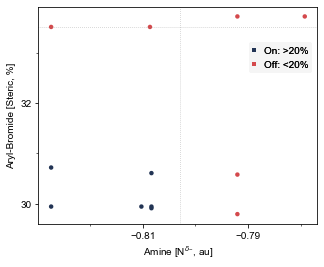

In [21]:
################################################
fig, ax = plt.subplots(figsize=(5, 4))  # Adjust the width and height as needed
ax.axvline(-0.803, color='grey', alpha=0.5,linewidth=0.75, linestyle='dotted')
ax.axhline(33.5, color='grey', alpha=0.5,linewidth=0.75, linestyle='dotted')

xT = grouped_ini_train.iloc[0:, 6]
yT = grouped_ini_train.iloc[0:, 5]
# xV = grouped_val.iloc[0:, 6]
# yV = grouped_val.iloc[0:, 5]
colors_T = np.where((xT < -0.803) & (yT < 33.509), '#223454', '#D4494C')
# colors_V = np.where((xV < -0.803) & (yV < 33.5), '#223454', '#D4494C')
scatter = plt.scatter(xT, yT, c=colors_T, marker='o', edgecolor="None", s=20, linewidth=0.5)
rows_prod = 1, 6, 8, 12, 13, 15
# edge_colors = ['black' if idx in rows_prod else 'None' for idx in range(len(xV))]
# scatter = plt.scatter(xV, yV, c=colors_V, marker='X', edgecolors=edge_colors, s=20, linewidth=0.5)
# scatter = plt.scatter(xT, yT, c=colors_T, marker='o', edgecolor='black', s=20, linewidth=0.5)
# scatter = plt.scatter(xV, yV, c=colors_V, marker='X', edgecolor='black', s=20, linewidth=0.5)
################################################
y_ticks = np.arange(30, 37.5, 2)
x_ticks = np.arange(-0.83, -0.77, 0.02)
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.minorticks_on()
minor_locator_x = MultipleLocator(0.02)  # Adjust the spacing as needed
minor_locator_y = MultipleLocator(1)   # Adjust the spacing as needed
plt.gca().xaxis.set_minor_locator(minor_locator_x)
plt.gca().yaxis.set_minor_locator(minor_locator_y)
plt.xlabel(r'Amine [N$^\delta$$^–$, au]')
plt.ylabel('Aryl-Bromide [Steric, %]')
################################################
# legend_entry_1 = plt.scatter([], [], c='white', edgecolor='black', s=20, marker='o', linewidth=0.5,  label="Training")
# legend_entry_2 = plt.scatter([], [], c='white', edgecolor='black', s=20, marker='X', linewidth=0.5, label="Validation")
# legend = plt.legend(handles=[legend_entry_1, legend_entry_2], loc='upper left', bbox_to_anchor=(0.01, 0.86),handlelength=0.3)
# legend.get_frame().set_alpha(None)
# legend.get_frame().set_facecolor((0,0,0, 0.05))
# legend.get_frame().set_edgecolor((0,0,0, 0.00))
# ax.add_artist(legend)
################################################
legend_entry_3 = plt.scatter([], [], c='#223454', edgecolor='black', s=20, marker='s', linewidth=0,  label="On: >20%")
legend_entry_4 = plt.scatter([], [], c='#D4494C', edgecolor='black', s=20, marker='s', linewidth=0, label="Off: <20%")
legend_2 = plt.legend(handles=[legend_entry_3, legend_entry_4], loc='upper right', bbox_to_anchor=(1.0, 0.86),handlelength=0.3)
legend_2.get_frame().set_alpha(None)
legend_2.get_frame().set_facecolor((0,0,0, 0.02))
legend_2.get_frame().set_edgecolor((0,0,0, 0.00))
ax.add_artist(legend_2)
################################################
# ax.axvline(-0.803, color='grey', alpha=0.5,linewidth=0.75, linestyle='dotted')
# ax.axhline(33.5, color='grey', alpha=0.5,linewidth=0.75, linestyle='dotted')
# plt.text(-0.795, 31.1, 'P201', c='black')
# plt.text(-0.83, 36.2, 'P206', c='black')
# plt.text(-0.825, 32.8, 'P208', c='black')
# plt.text(-0.83, 31, 'P215', c='black')
# plt.text(-0.807, 29.8, 'P213', c='black')
# plt.text(-0.785, 29.8, 'P212', c='black')
################################################

# plt.savefig("figure_1_new",dpi=600,bbox_inches = 'tight')
plt.show()

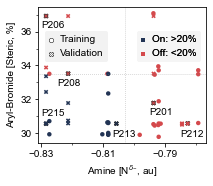

In [22]:
################################################
fig, ax = plt.subplots(figsize=(3, 2.5))  # Adjust the width and height as needed
ax.axvline(-0.803, color='grey', alpha=0.5,linewidth=0.75, linestyle='dotted')
ax.axhline(33.5, color='grey', alpha=0.5,linewidth=0.75, linestyle='dotted')

xT = grouped_train.iloc[0:, 6]
yT = grouped_train.iloc[0:, 5]
xV = grouped_val.iloc[0:, 6]
yV = grouped_val.iloc[0:, 5]
colors_T = np.where((xT < -0.803) & (yT < 33.509), '#223454', '#D4494C')
colors_V = np.where((xV < -0.803) & (yV < 33.509), '#223454', '#D4494C')
scatter = plt.scatter(xT, yT, c=colors_T, marker='o', edgecolor="None", s=20, linewidth=0.5)
rows_prod = 1, 6, 8, 12, 13, 15
edge_colors = ['black' if idx in rows_prod else 'None' for idx in range(len(xV))]
scatter = plt.scatter(xV, yV, c=colors_V, marker='X', edgecolors=edge_colors, s=20, linewidth=0.5)
# scatter = plt.scatter(xT, yT, c=colors_T, marker='o', edgecolor='black', s=20, linewidth=0.5)
# scatter = plt.scatter(xV, yV, c=colors_V, marker='X', edgecolor='black', s=20, linewidth=0.5)
################################################
y_ticks = np.arange(30, 37.5, 2)
x_ticks = np.arange(-0.83, -0.77, 0.02)
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.minorticks_on()
minor_locator_x = MultipleLocator(0.02)  # Adjust the spacing as needed
minor_locator_y = MultipleLocator(1)   # Adjust the spacing as needed
plt.gca().xaxis.set_minor_locator(minor_locator_x)
plt.gca().yaxis.set_minor_locator(minor_locator_y)
plt.xlabel(r'Amine [N$^\delta$$^–$, au]')
plt.ylabel('Aryl-Bromide [Steric, %]')
################################################
legend_entry_1 = plt.scatter([], [], c='white', edgecolor='black', s=20, marker='o', linewidth=0.5,  label="Training")
legend_entry_2 = plt.scatter([], [], c='white', edgecolor='black', s=20, marker='X', linewidth=0.5, label="Validation")
legend = plt.legend(handles=[legend_entry_1, legend_entry_2], loc='upper left', bbox_to_anchor=(0.01, 0.86),handlelength=0.3)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0,0,0, 0.05))
legend.get_frame().set_edgecolor((0,0,0, 0.00))
ax.add_artist(legend)
################################################
legend_entry_3 = plt.scatter([], [], c='#223454', edgecolor='black', s=20, marker='s', linewidth=0,  label="On: >20%")
legend_entry_4 = plt.scatter([], [], c='#D4494C', edgecolor='black', s=20, marker='s', linewidth=0, label="Off: <20%")
legend_2 = plt.legend(handles=[legend_entry_3, legend_entry_4], loc='upper right', bbox_to_anchor=(1.0, 0.86),handlelength=0.3)
legend_2.get_frame().set_alpha(None)
legend_2.get_frame().set_facecolor((0,0,0, 0.02))
legend_2.get_frame().set_edgecolor((0,0,0, 0.00))
ax.add_artist(legend_2)
################################################
# ax.axvline(-0.803, color='grey', alpha=0.5,linewidth=0.75, linestyle='dotted')
# ax.axhline(33.5, color='grey', alpha=0.5,linewidth=0.75, linestyle='dotted')
plt.text(-0.795, 31.1, 'P201', c='black')
plt.text(-0.83, 36.2, 'P206', c='black')
plt.text(-0.825, 32.8, 'P208', c='black')
plt.text(-0.83, 31, 'P215', c='black')
plt.text(-0.807, 29.8, 'P213', c='black')
plt.text(-0.785, 29.8, 'P212', c='black')
################################################

# plt.savefig("figure_val",dpi=600,bbox_inches = 'tight')
plt.show()

## EXTERNAL VALIDATION

There are 62 reactions with yields between 0-20%
There are 18 reactions with yields between 20%+


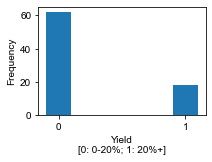

In [23]:
data_val = validation_df.copy()

properties_start = 5
response = 4

X_val = data_val.iloc[:,properties_start:].values
y_val = data_val["Yield"]
y_val = np.array([0 if i < 20 else 1 for i in y_val])
y_val = y_val.astype(int)

# XV_labelname = data_val.columns[properties_start:].tolist()

count_zero = np.count_nonzero(y_val == 0)
print(f"There are {count_zero} reactions with yields between 0-20%")
count_ones = np.count_nonzero(y_val == 1)
print(f"There are {count_ones} reactions with yields between 20%+")

fig, ax = plt.subplots(figsize=(3, 2))

# Your code to plot the histogram
plt.hist(y_val, bins=[-0.1, 0.1, 0.9, 1.1])
plt.xlabel('Yield \n[0: 0-20%; 1: 20%+]')
plt.ylabel('Frequency')
plt.xticks([0, 1])

plt.show()

Accuracy on validation data: 0.875
              precision    recall  f1-score   support

           0       0.96      0.87      0.92        62
           1       0.67      0.89      0.76        18

    accuracy                           0.88        80
   macro avg       0.82      0.88      0.84        80
weighted avg       0.90      0.88      0.88        80



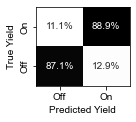

In [24]:
# get the predicted classes on the validation set
y_pred_val = model_final.predict(X_val)

# calculate the accuracy of the model on the validation set
accuracy_val = accuracy_score(y_val, y_pred_val)

print("Accuracy on validation data:", accuracy_val)

report = classification_report(y_val, y_pred_val)
print(report)

####################################################

fig, ax = plt.subplots(figsize=(2,1.8))
cm = confusion_matrix(y_val, y_pred_val, normalize='true')
cm = np.flipud(cm)

yticklabels = list(reversed(['Off', 'On'])) 
res = sns.heatmap(cm, annot=True, cmap='Greys', fmt='.1%',cbar=False, yticklabels=yticklabels)
for _, spine in res.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(0.75)
    
ax.set_xlabel('Predicted Yield')
ax.set_ylabel('True Yield',font="Arial")
ax.set_xticks([0.5, 1.5], ['Off', 'On'])
ax.set_yticks([0.5, 1.5], ['On', 'Off'])

fig.tight_layout()
# fig.savefig("cm-val.png", dpi=600, bbox_inches='tight')
plt.show()

# CONFIDENCE MAPS

## ENTROPY AND CONFIDENCE

### PREPARING DF

In [25]:
confidence = result_df.copy()

prefixes_to_find = ['Br_82_', 'Am_55_', 'Lig_2_'] 
selected_columns = confidence.columns[0:5].tolist()
found_columns = [col for col in confidence.columns if any(col.startswith(prefix) for prefix in prefixes_to_find)]
selected_columns.extend(found_columns)
confidence = result_df[selected_columns]

confidence.insert(5, 'yield-binary', np.where(confidence['Yield'] < 20, 0, 1))
#######################
threshold_1 = 2.068
threshold_2 = -0.803
threshold_3 =  33.509

Am = am_name
Br = br_name
Lig = lig_name

filtered_dt = confidence[confidence[Lig] <= threshold_1].copy()

filtered_dt["Prediction"] = 0
filtered_dt.loc[(filtered_dt[Am] <= threshold_2) & (filtered_dt[Br] <= threshold_3), "Prediction"] = 1

# display(filtered_dt)

### COUNTING CORRECT CLASSIFICATIONS

In [26]:
# Grouping by 'Product' and aggregating the counts
counts = filtered_dt.groupby('Product')['yield-binary'].value_counts().unstack()

# Renaming the columns for clarity
counts.columns = ['count_0', 'count_1']

# Resetting the index to make 'Product' a regular column
counts = counts.reset_index()

# Merging the counts DataFrame with the original DataFrame
merged_df = pd.merge(filtered_dt.drop('yield-binary', axis=1), counts, on='Product', how='left')

# Dropping duplicates and keeping the first occurrence of each product
merged_df = merged_df.drop_duplicates(subset='Product', keep='first')

# Reordering the columns
merged_df = merged_df[['Product', Br, Am,'Prediction', 'count_0', 'count_1']]

# Replacing NaN values with 0.001
merged_df = merged_df.fillna(0.001)

# Printing the updated DataFrame
display(merged_df)

,Product,Br_82_%Vbur_C_2.5Å_min,Am_55_NBO_charge_N_max,Prediction,count_0,count_1
0,P100,29.91275,-0.80836,1,4.0,15.000
19,P101,29.79555,-0.79202,0,19.0,0.001
38,P102,33.71858,-0.77921,0,17.0,2.000
57,P103,30.72015,-0.82743,1,6.0,13.000
76,P104,33.51022,-0.82743,0,19.0,0.001
...,...,...,...,...,...,...
561,P215,30.56876,-0.82849,1,1.0,2.000
564,P216,30.56876,-0.78447,0,3.0,0.001
567,P217,30.50690,-0.78447,0,3.0,0.001
570,P218,30.58178,-0.82849,1,1.0,2.000


### COMPUTING ENTROPY

In [27]:
# Calculate total count
merged_df['Total_Count'] = merged_df['count_0'] + merged_df['count_1']

# for index, row in merged_df.iterrows():
#     if row['Prediction'] == 0:
#         merged_df.loc[index, 'Confidence'] = -(row['count_0'] / row['Total_Count'])
#     elif row['Prediction'] == 1:
#         merged_df.loc[index, 'Confidence'] = row['count_1'] / row['Total_Count']

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)        

# Calculate total count
merged_df['Total_Count'] = merged_df['count_0'] + merged_df['count_1']

for index, row in merged_df.iterrows():
    total_count = row['Total_Count']
    count_0 = row['count_0']
    count_1 = row['count_1']

    if total_count > 0:
        p_0 = count_0 / total_count
        p_1 = count_1 / total_count

        # Calculate entropy
        if row['Prediction'] == 0:
            entropy = (p_0 * math.log2(p_0))
            merged_df.loc[index, 'Entropy'] = (-1 - entropy)*100

        elif row['Prediction'] == 1:
            entropy = -(p_1 * math.log2(p_1))
            merged_df.loc[index, 'Entropy'] = (1 - entropy)*100

        else:
            entropy = 0.0  # Invalid prediction, set entropy to 0.0

        # Set confidence as the complement of entropy (1 - entropy)
#         merged_dt.loc[index, 'Entropy'] = 1 - entropy
    else:
        merged_df.loc[index, 'Entropy'] = 0.0

merged_df.reset_index(drop=True, inplace=True)
display(merged_df)
# merged_df.to_excel('confidence.xlsx', index=False)

,Product,Br_82_%Vbur_C_2.5Å_min,Am_55_NBO_charge_N_max,Prediction,count_0,count_1,Total_Count,Entropy
0,P100,29.91275,-0.80836,1,4.000,15.000,19.000,73.076033
1,P101,29.79555,-0.79202,0,19.000,0.001,19.001,-99.992407
2,P102,33.71858,-0.77921,0,17.000,2.000,19.000,-85.642635
3,P103,30.72015,-0.82743,1,6.000,13.000,19.000,62.540309
4,P104,33.51022,-0.82743,0,19.000,0.001,19.001,-99.992407
5,P105,29.94531,-0.82743,1,2.000,17.000,19.000,85.642635
6,P106,33.51022,-0.80864,0,18.000,1.000,19.000,-92.610288
7,P107,30.60945,-0.80836,1,9.000,10.000,19.000,51.263188
8,P108,29.94531,-0.80836,1,5.000,14.000,19.000,67.536756
9,P109,29.94531,-0.81027,1,4.000,15.000,19.000,73.076033


## PLOTS

### PREPARING DF

In [28]:
conf_training = merged_df[merged_df['Product'].str[1:].astype(int) < 200]
conf_validation = merged_df[merged_df['Product'].str[1:].astype(int) >= 200]
# display(conf_validation)

confidence = merged_df["Entropy"]
x = merged_df[Am]
y = merged_df[Br]

confidence_T = conf_training["Entropy"]
confidence_V = conf_validation["Entropy"]
xT = conf_training[Am]
yT = conf_training[Br]
xV = conf_validation[Am]
yV = conf_validation[Br]

x_norm = (x - min(x)) / (max(x) - min(x))
y_norm = (y - min(y)) / (max(y) - min(y))
xT_norm = (xT - min(x)) / (max(x) - min(x))
yT_norm = (yT - min(y)) / (max(y) - min(y))
xV_norm = (xV - min(x)) / (max(x) - min(x))
yV_norm = (yV - min(y)) / (max(y) - min(y))

thresh_x = (threshold_2 - min(x)) / (max(x) - min(x))
thresh_y = (threshold_3 - min(y)) / (max(y) - min(y))

# display(confidence)

### HEATMAP

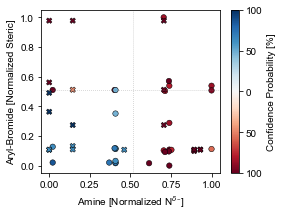

In [29]:
###########
fig, ax = plt.subplots(figsize=(4, 3))  

scatter = plt.scatter(xT_norm, yT_norm, c=confidence_T, marker='o', s=30, cmap='RdBu', edgecolors='black', linewidth=0.5, vmin=-100, vmax=100)
scatter = plt.scatter(xV_norm, yV_norm, c=confidence_V, marker='X', s=30, cmap='RdBu', edgecolors='black', linewidth=0.5, vmin=-100, vmax=100)

colorbar = plt.colorbar(scatter)
colorbar.set_label('Confidence Probability [%]', fontsize=10)

###########
ticks = np.array([100, 50, 0, -50, -100])
ticklabels = [f"{abs(t):.0f}" for t in ticks]
colorbar.set_ticks(ticks)
colorbar.set_ticklabels(ticklabels)

###########
plt.xlabel(r'Amine [Normalized N$^\delta$$^–$]')
plt.ylabel('Aryl-Bromide [Normalized Steric]')
ax.axvline(thresh_x, color='grey', alpha=0.5,linewidth=0.75, linestyle='dotted')
ax.axhline(thresh_y, color='grey', alpha=0.5,linewidth=0.75, linestyle='dotted')
######
# plt.savefig("contour_1",dpi=600,bbox_inches = 'tight')
plt.show()

### RADIAL BASIS FUNCTION INTERPOLATION

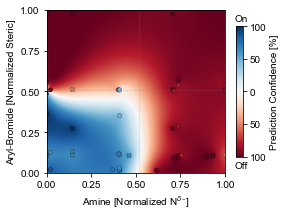

In [30]:
####
rbf = Rbf(x_norm, y_norm, confidence, function='linear', epsilon=0.1, smooth=0.02) #0.02
####
x_grid, y_grid = np.meshgrid(np.linspace(0, 1, 500), np.linspace(0, 1, 500))
confidence_interp = rbf(x_grid, y_grid)
confidence_interp_norm = np.clip(confidence_interp, -100, 100)
################################################
fig, ax = plt.subplots(figsize=(4, 3)) 
contour = ax.contourf(x_grid, y_grid, confidence_interp_norm, cmap='RdBu', alpha=1.0, levels=500, vmin=-100, vmax=100)
################################################
scatter_1 = plt.scatter(xV_norm, yV_norm, c=confidence_V, marker='X', s=20, cmap='RdBu', alpha=1, edgecolors="black", linewidth=0.25, vmin=-100, vmax=100)
scatter_2 = plt.scatter(xT_norm, yT_norm, c=confidence_T, marker='o', s=20, cmap='RdBu', alpha=1, edgecolors="black", linewidth=0.25, vmin=-100, vmax=100)
################################################
colorbar = plt.colorbar(scatter_1, shrink=0.80)
ticks = np.array([100, 50, 0, -50, -100])
ticklabels = [f"{abs(t):.0f}" for t in ticks]
colorbar.set_ticks(ticks)
colorbar.set_ticklabels(ticklabels)
colorbar.set_label('Prediction Confidence [%]')
plt.text(1.05, 0.03, 'Off', c='black', transform=plt.gca().transAxes)
plt.text(1.05, 0.93, 'On', c='black', transform=plt.gca().transAxes)
################################################
custom_ticks = [0, 0.25, 0.5, 0.75, 1.0]
plt.xticks(custom_ticks)
plt.yticks(custom_ticks)
plt.xlabel(r'Amine [Normalized N$^\delta$$^–$]')
plt.ylabel('Aryl-Bromide [Normalized Steric]')
ax.axvline(thresh_x, color='grey', alpha=0.5,linewidth=0.75, linestyle='dotted')
ax.axhline(thresh_y, color='grey', alpha=0.5,linewidth=0.75, linestyle='dotted')
######
# plt.savefig("confidence",dpi=600,bbox_inches = 'tight')
plt.show()

## P123

The confidence value is: [-88.01486429 -84.49100235 -96.20162512]


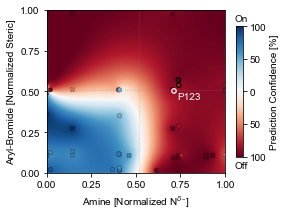

In [31]:
################################################
X = np.array([-0.79333, -0.79202, -0.79214])
Y = np.array([33.459760, 33.718583, 33.949733])
################################################
x_target_norm = (X - min(x)) / (max(x) - min(x))
y_target_norm = (Y - min(y)) / (max(y) - min(y))
input_data = np.column_stack((x_target_norm, y_target_norm))
confidence_pred = rbf(x_target_norm, y_target_norm)
print(f'The confidence value is: {confidence_pred}')
################################################
fig, ax = plt.subplots(figsize=(4, 3)) 
contour = ax.contourf(x_grid, y_grid, confidence_interp_norm, cmap='RdBu', alpha=1.0, levels=500, vmin=-100, vmax=100)
################################################
scatter_1 = plt.scatter(xV_norm, yV_norm, c=confidence_V, marker='X', s=20, cmap='RdBu', alpha=1, edgecolors="black", linewidth=0.25, vmin=-100, vmax=100)
scatter_2 = plt.scatter(xT_norm, yT_norm, c=confidence_T, marker='o', s=20, cmap='RdBu', alpha=1, edgecolors="black", linewidth=0.25, vmin=-100, vmax=100)
scatter_3 = plt.scatter(input_data[:1, 0], input_data[:1, 1],c="None", marker='o', s=20, edgecolors='white', linewidth=1.25, vmin=-100, vmax=100)
scatter_3 = plt.scatter(input_data[1:, 0], input_data[1:, 1],c="None", marker='o', s=20, edgecolors='black', linewidth=1.25, vmin=-100, vmax=100)
################################################
colorbar = plt.colorbar(scatter_1, shrink=0.80)
ticks = np.array([100, 50, 0, -50, -100])
ticklabels = [f"{abs(t):.0f}" for t in ticks]
colorbar.set_ticks(ticks)
colorbar.set_ticklabels(ticklabels)
colorbar.set_label('Prediction Confidence [%]')
plt.text(1.05, 0.03, 'Off', c='black', transform=plt.gca().transAxes)
plt.text(1.05, 0.93, 'On', c='black', transform=plt.gca().transAxes)
################################################
custom_ticks = [0, 0.25, 0.5, 0.75, 1.0]
plt.xticks(custom_ticks)
plt.yticks(custom_ticks)
plt.xlabel(r'Amine [Normalized N$^\delta$$^–$]')
plt.ylabel('Aryl-Bromide [Normalized Steric]')
plt.text(0.73, 0.45, 'P123', c='white')
# plt.text(0.76, 0.51, 'P111', c='white')
# plt.text(0.76, 0.58, 'P125', c='white')
ax.axvline(thresh_x, color='grey', alpha=0.5,linewidth=0.75, linestyle='dotted')
ax.axhline(thresh_y, color='grey', alpha=0.5,linewidth=0.75, linestyle='dotted')
######
# plt.savefig("confidence",dpi=600,bbox_inches = 'tight')
plt.show()

## P300

The confidence value is: [66.19440478 63.88936792 82.41044153]


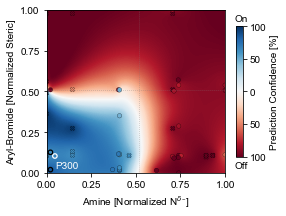

In [32]:
#P300
################################################
X = np.array([-0.8262, -0.82743, -0.82743])
Y = np.array([30.554109, 30.720146, 29.945305])
################################################
x_target_norm = (X - min(x)) / (max(x) - min(x))
y_target_norm = (Y - min(y)) / (max(y) - min(y))
input_data = np.column_stack((x_target_norm, y_target_norm))
confidence_pred = rbf(x_target_norm, y_target_norm)
print(f'The confidence value is: {confidence_pred}')
################################################
fig, ax = plt.subplots(figsize=(4, 3)) 
contour = ax.contourf(x_grid, y_grid, confidence_interp_norm, cmap='RdBu', alpha=1.0, levels=500, vmin=-100, vmax=100)
################################################
scatter_1 = plt.scatter(xV_norm, yV_norm, c=confidence_V, marker='X', s=20, cmap='RdBu', alpha=1, edgecolors="black", linewidth=0.25, vmin=-100, vmax=100)
scatter_2 = plt.scatter(xT_norm, yT_norm, c=confidence_T, marker='o', s=20, cmap='RdBu', alpha=1, edgecolors="black", linewidth=0.25, vmin=-100, vmax=100)
scatter_3 = plt.scatter(input_data[:1, 0], input_data[:1, 1],c="None", marker='o', s=20, edgecolors='white', linewidth=1.25, vmin=-100, vmax=100)
scatter_3 = plt.scatter(input_data[1:, 0], input_data[1:, 1],c="None", marker='o', s=20, edgecolors='black', linewidth=1.25, vmin=-100, vmax=100)
################################################
colorbar = plt.colorbar(scatter_1, shrink=0.80)
ticks = np.array([100, 50, 0, -50, -100])
ticklabels = [f"{abs(t):.0f}" for t in ticks]
colorbar.set_ticks(ticks)
colorbar.set_ticklabels(ticklabels)
colorbar.set_label('Prediction Confidence [%]')
plt.text(1.05, 0.03, 'Off', c='black', transform=plt.gca().transAxes)
plt.text(1.05, 0.93, 'On', c='black', transform=plt.gca().transAxes)
################################################
custom_ticks = [0, 0.25, 0.5, 0.75, 1.0]
plt.xticks(custom_ticks)
plt.yticks(custom_ticks)
plt.xlabel(r'Amine [Normalized N$^\delta$$^–$]')
plt.ylabel('Aryl-Bromide [Normalized Steric]')
plt.text(0.05, 0.03, 'P300', c='white', transform=plt.gca().transAxes)
ax.axvline(thresh_x, color='grey', alpha=0.5,linewidth=0.75, linestyle='dotted')
ax.axhline(thresh_y, color='grey', alpha=0.5,linewidth=0.75, linestyle='dotted')
######
# plt.savefig("confidence_P300",dpi=600,bbox_inches = 'tight')
plt.show()

## P301

The confidence value is: [-90.75702183 -62.55086038 -86.96019198]


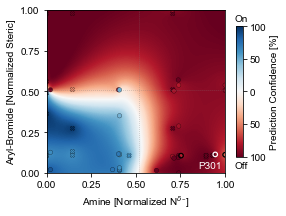

In [33]:
#P301 #30.609454	-0.77921	 ; 30.570387	-0.79138
################################################
X = np.array([-0.78194, -0.77921, -0.79138])
Y = np.array([30.625733, 30.609454, 30.570387])
################################################
x_target_norm = (X - min(x)) / (max(x) - min(x))
y_target_norm = (Y - min(y)) / (max(y) - min(y))
input_data = np.column_stack((x_target_norm, y_target_norm))
confidence_pred = rbf(x_target_norm, y_target_norm)
print(f'The confidence value is: {confidence_pred}')
################################################
fig, ax = plt.subplots(figsize=(4, 3)) 
contour = ax.contourf(x_grid, y_grid, confidence_interp_norm, cmap='RdBu', alpha=1.0, levels=500, vmin=-100, vmax=100)
################################################
scatter_1 = plt.scatter(xV_norm, yV_norm, c=confidence_V, marker='X', s=20, cmap='RdBu', alpha=1, edgecolors="black", linewidth=0.25, vmin=-100, vmax=100)
scatter_2 = plt.scatter(xT_norm, yT_norm, c=confidence_T, marker='o', s=20, cmap='RdBu', alpha=1, edgecolors="black", linewidth=0.25, vmin=-100, vmax=100)
scatter_3 = plt.scatter(input_data[:1, 0], input_data[:1, 1],c="None", marker='o', s=20, edgecolors='white', linewidth=1.25, vmin=-100, vmax=100)
scatter_3 = plt.scatter(input_data[1:, 0], input_data[1:, 1],c="None", marker='o', s=20, edgecolors='black', linewidth=1.25, vmin=-100, vmax=100)
################################################
colorbar = plt.colorbar(scatter_1, shrink=0.80)
ticks = np.array([100, 50, 0, -50, -100])
ticklabels = [f"{abs(t):.0f}" for t in ticks]
colorbar.set_ticks(ticks)
colorbar.set_ticklabels(ticklabels)
colorbar.set_label('Prediction Confidence [%]')
plt.text(1.05, 0.03, 'Off', c='black', transform=plt.gca().transAxes)
plt.text(1.05, 0.93, 'On', c='black', transform=plt.gca().transAxes)
################################################
custom_ticks = [0, 0.25, 0.5, 0.75, 1.0]
plt.xticks(custom_ticks)
plt.yticks(custom_ticks)
plt.xlabel(r'Amine [Normalized N$^\delta$$^–$]')
plt.ylabel('Aryl-Bromide [Normalized Steric]')
plt.text(0.85, 0.03, 'P301', c='white', transform=plt.gca().transAxes)
ax.axvline(thresh_x, color='grey', alpha=0.5,linewidth=0.75, linestyle='dotted')
ax.axhline(thresh_y, color='grey', alpha=0.5,linewidth=0.75, linestyle='dotted')
######
# plt.savefig("confidence_P301",dpi=600,bbox_inches = 'tight')
plt.show()

# KNN 

In [34]:
pd.set_option('display.max_rows', 10)

columns_knn = ["Product", "Ligands", "Yield", br_name, am_name]
knn_df = training_df[columns_knn].copy() 

scaler = MinMaxScaler()
knn_df['Br_Norm'] = scaler.fit_transform(knn_df[[br_name]])
knn_df['Am_Norm'] = scaler.fit_transform(knn_df[[am_name]])
knn_df.drop(columns=[am_name, br_name], inplace=True)

#####
knn_df = knn_df.sort_values(by=["Product", "Yield"], ascending=[True, False])

top_5_dict = {}
for product, group in knn_df.groupby("Product"):
    top_5_yields = group["Yield"].head(5).tolist()
    top_5_dict[product] = top_5_yields

knn_df["top_5"] = knn_df.apply(lambda row: 1 if row["Yield"] in top_5_dict[row["Product"]] else 0, axis=1)
knn_df = knn_df.reset_index(drop=True)

knn_df = knn_df[knn_df["top_5"] == 1]
knn_df = knn_df.reset_index(drop=True)
knn_df.drop(columns="top_5", inplace=True)

pd.set_option('display.max_rows', 10)
display(knn_df)

,Product,Ligands,Yield,Br_Norm,Am_Norm
0,P100,Ligand_36,59.225023,0.016093,0.395479
1,P100,Ligand_27,54.574285,0.016093,0.395479
2,P100,Ligand_31,51.358607,0.016093,0.395479
3,P100,Ligand_19,49.685778,0.016093,0.395479
4,P100,Ligand_34,45.684501,0.016093,0.395479
...,...,...,...,...,...
148,P127,Ligand_26,29.219133,0.111756,1.000000
149,P127,Ligand_31,27.894275,0.111756,1.000000
150,P127,Ligand_35,24.007300,0.111756,1.000000
151,P127,Ligand_29,23.954664,0.111756,1.000000


In [35]:
clean_df = knn_df.copy()
clean_df.drop(columns=["Yield"], inplace=True)

# Create a new column for ligand ranks within each product group
clean_df['Lig_Rank'] = clean_df.groupby('Product').cumcount() + 1

# Pivot the DataFrame to have Lig_1, Lig_2, Lig_3 columns
pivoted_df = clean_df.pivot(index='Product', columns='Lig_Rank', values='Ligands').reset_index()

# Combine the pivoted DataFrame with the "Br_Norm" and "Am_Norm" columns
pivoted_df[['Br_Norm', 'Am_Norm']] = clean_df.groupby('Product')[['Br_Norm', 'Am_Norm']].first().reset_index()[['Br_Norm', 'Am_Norm']]
pivoted_df.rename(columns={
    'Br_Norm': 'Br_Norm',
    'Am_Norm': 'Am_Norm',
    1: 'Top_1',
    2: 'Top_2',
    3: 'Top_3',
    4: 'Top_4',
    5: 'Top_5'
}, inplace=True)
pivoted_df = pivoted_df.dropna(axis=1)
prod_info_df = pivoted_df.copy()
################################################################
neighbors = NearestNeighbors(n_neighbors=3)
neighbors.fit(prod_info_df[['Br_Norm', 'Am_Norm']])
distances, nearest_neighbor_idx = neighbors.kneighbors(prod_info_df[['Br_Norm', 'Am_Norm']])
prod_info_df['NN_1'] = prod_info_df.loc[nearest_neighbor_idx[:, 1], 'Product'].values
prod_info_df['NN_2'] = prod_info_df.loc[nearest_neighbor_idx[:, 2], 'Product'].values

display(prod_info_df)

Lig_Rank,Product,Top_1,Top_2,Top_3,Top_4,Top_5,Br_Norm,Am_Norm,NN_1,NN_2
0,P100,Ligand_36,Ligand_27,Ligand_31,Ligand_19,Ligand_34,0.016093,0.395479,P108,P120
1,P101,Ligand_18,Ligand_11,Ligand_24,Ligand_21,Ligand_22,0.000000,0.734343,P121,P118
2,P102,Ligand_28,Ligand_27,Ligand_29,Ligand_26,Ligand_31,0.538667,1.000000,P126,P111
3,P103,Ligand_30,Ligand_28,Ligand_26,Ligand_31,Ligand_33,0.126956,0.000000,P105,P109
4,P104,Ligand_26,Ligand_32,Ligand_28,Ligand_15,Ligand_18,0.510057,0.000000,P103,P106
...,...,...,...,...,...,...,...,...,...,...
23,P123,Ligand_26,Ligand_29,Ligand_25,Ligand_23,Ligand_22,0.503129,0.707175,P111,P125
24,P124,Ligand_28,Ligand_27,Ligand_29,Ligand_26,Ligand_25,1.000000,0.698880,P125,P111
25,P125,Ligand_25,Ligand_28,Ligand_26,Ligand_23,Ligand_27,0.570406,0.731854,P111,P123
26,P126,Ligand_26,Ligand_22,Ligand_34,Ligand_29,Ligand_25,0.506928,1.000000,P102,P111


In [120]:
new_df = prod_info_df.copy()

def check_ligands_in_nn(row, nn_column):
    nn_product = row[nn_column]
    nn_row = prod_info_df[prod_info_df["Product"] == nn_product]
    if nn_row.empty:
        return False
    
    nn_ligands = set(nn_row[["Top_1", "Top_2", "Top_3"]].values[0])
    row_ligands = set(row[["Top_1", "Top_2", "Top_3", "Top_4", "Top_5"]].values)
    return any(ligand in nn_ligands for ligand in row_ligands)

new_df["Check_NN_1"] = new_df.apply(lambda row: check_ligands_in_nn(row, "NN_1"), axis=1)
new_df["Check_NN_2"] = new_df.apply(lambda row: check_ligands_in_nn(row, "NN_2"), axis=1)

new_df["check"] = new_df["Check_NN_1"] | new_df["Check_NN_2"]
# Assuming "new_df" is your DataFrame
true_count = new_df["check"].sum()

print("Number of True values in the 'check' column:", true_count)
pd.set_option('display.max_rows', None)
display(new_df)

# new_df.to_excel('knn.xlsx', index=False)

Number of True values in the 'check' column: 26


Lig_Rank,Product,Top_1,Top_2,Top_3,Top_4,Top_5,Br_Norm,Am_Norm,NN_1,NN_2,Check_NN_1,Check_NN_2,check
0,P100,Ligand_36,Ligand_27,Ligand_31,Ligand_19,Ligand_34,0.016093,0.395479,P108,P120,True,True,True
1,P101,Ligand_18,Ligand_11,Ligand_24,Ligand_21,Ligand_22,0.000000,0.734343,P121,P118,False,False,False
2,P102,Ligand_28,Ligand_27,Ligand_29,Ligand_26,Ligand_31,0.538667,1.000000,P126,P111,True,True,True
3,P103,Ligand_30,Ligand_28,Ligand_26,Ligand_31,Ligand_33,0.126956,0.000000,P105,P109,True,True,True
4,P104,Ligand_26,Ligand_32,Ligand_28,Ligand_15,Ligand_18,0.510057,0.000000,P103,P106,True,False,True
5,P105,Ligand_35,Ligand_36,Ligand_33,Ligand_31,Ligand_34,0.020563,0.000000,P103,P109,False,True,True
6,P106,Ligand_29,Ligand_25,Ligand_33,Ligand_32,Ligand_24,0.510057,0.389672,P122,P113,True,False,True
7,P107,Ligand_30,Ligand_31,Ligand_36,Ligand_32,Ligand_29,0.111756,0.395479,P115,P116,True,True,True
8,P108,Ligand_21,Ligand_19,Ligand_24,Ligand_31,Ligand_29,0.020563,0.395479,P100,P120,True,True,True
9,P109,Ligand_19,Ligand_24,Ligand_31,Ligand_21,Ligand_36,0.020563,0.355869,P108,P100,True,True,True


## KNN P123, P200 & P201

### P123

The confidence value is: [-88.01486429]
Product: P123
Top three ligands with highest yield:
Ligand: Ligand_26, Yield: 24.550430335328866
Ligand: Ligand_29, Yield: 20.72536739012317
Ligand: Ligand_25, Yield: 16.22608248062691

Product: P111
Top three ligands with highest yield:
Ligand: Ligand_29, Yield: 21.568127525999042
Ligand: Ligand_19, Yield: 21.446753739457716
Ligand: Ligand_28, Yield: 20.168890091545645

Product: P125
Top three ligands with highest yield:
Ligand: Ligand_25, Yield: 17.39565486885033
Ligand: Ligand_28, Yield: 13.25197285670327
Ligand: Ligand_26, Yield: 9.546501636747392



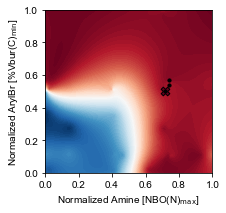

In [36]:
################################################
X = np.array([-0.79333])
Y = np.array([33.459760])
############################################################
x_target_norm = (X - min(x)) / (max(x) - min(x))
y_target_norm = (Y - min(y)) / (max(y) - min(y))
input_data = np.column_stack((x_target_norm, y_target_norm))
confidence_pred = rbf(x_target_norm, y_target_norm)
print(f'The confidence value is: {confidence_pred}')
############################################################
data_points = np.column_stack((xT_norm, yT_norm))
knn = NearestNeighbors(n_neighbors=3)
knn.fit(data_points)
distances, indices = knn.kneighbors(input_data)

x_neighbors = np.expand_dims(xT_norm[indices[0]], axis=1)
y_neighbors = np.expand_dims(yT_norm[indices[0]], axis=1)
neighbors_data = np.hstack((x_neighbors, y_neighbors))
############################################################
unique_products = merged_df.iloc[indices.flatten()]["Product"].unique()

for product in unique_products:
    product_df = data[data["Product"] == product]
    sorted_df = product_df.sort_values("Yield", ascending=False)
    top_three_yields = sorted_df["Yield"].head(3)
    top_three_ligands = sorted_df.loc[sorted_df["Yield"].isin(top_three_yields), "Ligands"]
    top_three_yield_values = sorted_df.loc[sorted_df["Yield"].isin(top_three_yields), "Yield"]
    print(f"Product: {product}")
    print("Top three ligands with highest yield:")
    for ligand, yield_value in zip(top_three_ligands, top_three_yield_values):
        print(f"Ligand: {ligand}, Yield: {yield_value}")
    print()

############################################################
plt.figure(figsize=(3, 3))  # Set the figure size to 6 inches by 4 inches
contour = plt.contourf(x_grid, y_grid, confidence_interp, cmap='RdBu', levels=100)
scatter = plt.scatter(input_data[:, 0], input_data[:, 1],c=confidence_pred,cmap='RdBu', marker='X', s=75, edgecolors='black', linewidth=1, vmin=-1, vmax=1)
scatter = plt.scatter(neighbors_data[:, 0], neighbors_data[:, 1], marker='o', s=10, color='black', linewidth=1)
plt.xlabel('Normalized Amine [NBO(N)$_{\mathrm{max}}$]')
plt.ylabel('Normalized ArylBr [%Vbur(C)$_{\mathrm{min}}$]')

plt.show()

### P300

The confidence value is: [66.19440478]
Product: P103
Top three ligands with highest yield:
Ligand: Ligand_30, Yield: 50.949309481774705
Ligand: Ligand_28, Yield: 50.557890342298464
Ligand: Ligand_26, Yield: 39.813095086328076

Product: P105
Top three ligands with highest yield:
Ligand: Ligand_35, Yield: 99.98473581601128
Ligand: Ligand_36, Yield: 93.72598601096004
Ligand: Ligand_33, Yield: 86.85144202218417

Product: P109
Top three ligands with highest yield:
Ligand: Ligand_19, Yield: 68.035525
Ligand: Ligand_24, Yield: 64.0
Ligand: Ligand_31, Yield: 48.65543753033767



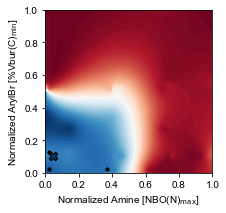

In [37]:
############################################################
X = np.array([-0.8262])
Y = np.array([30.554109])
############################################################
x_target_norm = (X - min(x)) / (max(x) - min(x))
y_target_norm = (Y - min(y)) / (max(y) - min(y))
input_data = np.column_stack((x_target_norm, y_target_norm))
confidence_pred = rbf(x_target_norm, y_target_norm)
print(f'The confidence value is: {confidence_pred}')
############################################################
data_points = np.column_stack((xT_norm, yT_norm))
knn = NearestNeighbors(n_neighbors=3)
knn.fit(data_points)
distances, indices = knn.kneighbors(input_data)

x_neighbors = np.expand_dims(xT_norm[indices[0]], axis=1)
y_neighbors = np.expand_dims(yT_norm[indices[0]], axis=1)
neighbors_data = np.hstack((x_neighbors, y_neighbors))
############################################################
unique_products = merged_df.iloc[indices.flatten()]["Product"].unique()

for product in unique_products:
    product_df = data[data["Product"] == product]
    sorted_df = product_df.sort_values("Yield", ascending=False)
    top_three_yields = sorted_df["Yield"].head(3)
    top_three_ligands = sorted_df.loc[sorted_df["Yield"].isin(top_three_yields), "Ligands"]
    top_three_yield_values = sorted_df.loc[sorted_df["Yield"].isin(top_three_yields), "Yield"]
    print(f"Product: {product}")
    print("Top three ligands with highest yield:")
    for ligand, yield_value in zip(top_three_ligands, top_three_yield_values):
        print(f"Ligand: {ligand}, Yield: {yield_value}")
    print()

############################################################
plt.figure(figsize=(3, 3))  # Set the figure size to 6 inches by 4 inches
contour = plt.contourf(x_grid, y_grid, confidence_interp, cmap='RdBu', levels=100)
scatter = plt.scatter(input_data[:, 0], input_data[:, 1],c=confidence_pred,cmap='RdBu', marker='X', s=75, edgecolors='black', linewidth=1, vmin=-1, vmax=1)
scatter = plt.scatter(neighbors_data[:, 0], neighbors_data[:, 1], marker='o', s=10, color='black', linewidth=1)
plt.xlabel('Normalized Amine [NBO(N)$_{\mathrm{max}}$]')
plt.ylabel('Normalized ArylBr [%Vbur(C)$_{\mathrm{min}}$]')

plt.show()

### P301

The confidence value is: [-90.75702183]
Product: P127
Top three ligands with highest yield:
Ligand: Ligand_26, Yield: 29.21913345743088
Ligand: Ligand_31, Yield: 27.894275487592978
Ligand: Ligand_35, Yield: 24.00730008807943

Product: P117
Top three ligands with highest yield:
Ligand: Ligand_22, Yield: 22.3883158288444
Ligand: Ligand_24, Yield: 21.277025106752298
Ligand: Ligand_21, Yield: 20.02470258904745

Product: P110
Top three ligands with highest yield:
Ligand: Ligand_30, Yield: 17.691048650941656
Ligand: Ligand_28, Yield: 16.811731487305188
Ligand: Ligand_26, Yield: 14.082697617772649



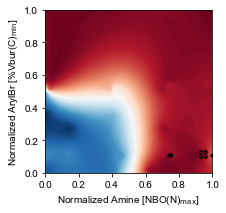

In [38]:
############################################################
X = np.array([-0.78194])
Y = np.array([30.625733])
############################################################
x_target_norm = (X - min(x)) / (max(x) - min(x))
y_target_norm = (Y - min(y)) / (max(y) - min(y))
input_data = np.column_stack((x_target_norm, y_target_norm))
confidence_pred = rbf(x_target_norm, y_target_norm)
print(f'The confidence value is: {confidence_pred}')
############################################################
data_points = np.column_stack((xT_norm, yT_norm))
knn = NearestNeighbors(n_neighbors=3)
knn.fit(data_points)
distances, indices = knn.kneighbors(input_data)

x_neighbors = np.expand_dims(xT_norm[indices[0]], axis=1)
y_neighbors = np.expand_dims(yT_norm[indices[0]], axis=1)
neighbors_data = np.hstack((x_neighbors, y_neighbors))
############################################################
unique_products = merged_df.iloc[indices.flatten()]["Product"].unique()

for product in unique_products:
    product_df = data[data["Product"] == product]
    sorted_df = product_df.sort_values("Yield", ascending=False)
    top_three_yields = sorted_df["Yield"].head(3)
    top_three_ligands = sorted_df.loc[sorted_df["Yield"].isin(top_three_yields), "Ligands"]
    top_three_yield_values = sorted_df.loc[sorted_df["Yield"].isin(top_three_yields), "Yield"]
    print(f"Product: {product}")
    print("Top three ligands with highest yield:")
    for ligand, yield_value in zip(top_three_ligands, top_three_yield_values):
        print(f"Ligand: {ligand}, Yield: {yield_value}")
    print()

############################################################
plt.figure(figsize=(3, 3))  # Set the figure size to 6 inches by 4 inches
contour = plt.contourf(x_grid, y_grid, confidence_interp, cmap='RdBu', levels=100)
scatter = plt.scatter(input_data[:, 0], input_data[:, 1],c=confidence_pred,cmap='RdBu', marker='X', s=75, edgecolors='black', linewidth=1, vmin=-1, vmax=1)
scatter = plt.scatter(neighbors_data[:, 0], neighbors_data[:, 1], marker='o', s=10, color='black', linewidth=1)
plt.xlabel('Normalized Amine [NBO(N)$_{\mathrm{max}}$]')
plt.ylabel('Normalized ArylBr [%Vbur(C)$_{\mathrm{min}}$]')

plt.show()

# EXPORTS

## KNN

In [ ]:
# filename = 'knn_model.pkl'
# with open(filename, 'wb') as file:
#     pickle.dump(knn, file)

In [ ]:
# # Export data to a pickle file
# data.to_pickle('data.pkl')

# # Export knn_df to a pickle file
# knn_df.to_pickle('knn_df.pkl')

# # Export merged_df to a pickle file
# merged_df.to_pickle('merged_df.pkl')

## CONFIDENCE

In [ ]:
# filename = 'confidence_model.pkl'
# with open(filename, 'wb') as file:
#     pickle.dump(rbf, file)